In [1]:
#from google.colab import drive

In [2]:
#drive.mount('/content/drive')

In [3]:
#import os
#os.chdir("/content/drive")

In [4]:
#cd My Drive

In [5]:
#cd CS230-master

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import time
%matplotlib inline
# 
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

In [7]:
import os; 
#work-around to allow import from directory on same level
os.sys.path.append(os.path.dirname(os.path.abspath('.')))
from input.DataLoader import DataLoader
from input.GenerateBatch import GenerateBatch
from model.Model3 import train_generator

Using TensorFlow backend.


In [8]:
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout,Activation, Lambda
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import  MaxPooling1D, MaxPooling2D,Reshape, BatchNormalization
from keras.utils import to_categorical
from keras.metrics import categorical_crossentropy
from scipy.stats import linregress
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from keras.backend import transpose, permute_dimensions,squeeze
from keras.optimizers import Adam

#### Transfer Learning Experiment - Is it better to train on a set of stocks or just on the one you want to predict
#### Particularly important in cases like this where only limited data is available
#### For stock S Compare Two Models
#### First Model; Fit on five stocks (including S) and then predict S
#### Second Model: Fit and predict just on S

In [9]:
# PARAMETERS AND COMMENTs
#
# LSTM with 10bar target and 0-5.6-7 training/val 
# Train and predict for one stock vs training on all stocks and predicting on one
# standardize window = false
# Dropout back to 50;
# L2 Regularization on dense layer
configs={}
configs['batch_size']=500

configs['sequence_length']=20
configs['epochs']=100
configs['learning_rate']=.001
configs['learning_rate_decay']=0
configs['opt']=Adam(lr=configs['learning_rate'],
                   decay=configs['learning_rate_decay'])
configs['save_dir']='saved_models'
configs['nflag']=False #standardize each window
configs['stock']=0 # Predict first stock using the two approaches


traindays=[0,1,2,3,4,5] #training and val days to look at in dataset
valdays=[6,7]
colx=range(40)# columns to look at in dataset - 0-40 are LOB
#colx=np.concatenate([np.arange(20),86+np.arange(20)])
coly=148 # target 144-148 are 1,2,3,5,10
generate_files=False
print('trainday',traindays,'valdays',valdays,'colx',colx,'coly',coly)
print(configs)

trainday [0, 1, 2, 3, 4, 5] valdays [6, 7] colx range(0, 40) coly 148
{'batch_size': 500, 'sequence_length': 20, 'epochs': 100, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'opt': <keras.optimizers.Adam object at 0x7efed4b10f98>, 'save_dir': 'saved_models', 'nflag': False, 'stock': 0}


### Generate data from zip files or retrieve from pkl files in directory

In [10]:
if generate_files==True:
  path='data/'
  d=DataLoader(path)
  traindf=d.get_days(traindays)
  trainoffset=d.get_stock_offset(traindays)
  valdf=d.get_days(valdays)
  valoffset=d.get_stock_offset(valdays)

  traindf.to_pickle("traindf.pkl")
  valdf.to_pickle("valdf.pkl")
  np.save("trainoffset",trainoffset)
  np.save("valoffset",valoffset)

else:
  traindf=pd.read_pickle('traindf.pkl')
  valdf=pd.read_pickle('valdf.pkl')
  trainoffset=np.load("trainoffset.npy")
  valoffset=np.load("valoffset.npy")

# Select X and Y training and dev data. Y is categorical
trainx=traindf.iloc[:,colx].values
trainy=to_categorical(traindf.iloc[:,coly].values-1)
valx=valdf.iloc[:,colx].values
valy=to_categorical(valdf.iloc[:,coly].values-1)



### Function to extract LOB data for a list of stocks from trainx and trainy

In [11]:
# select a subset of stocks
def select_stocks(s,dat,offset,ndays):
    ###############
    # Inputs:
    # s: list of stocks to select
    # dat: numpy array of data - shape rows are successive LOB snapshots; columns are data items (bid, ask...)
    # offset: offset to end of each stock in succession on each day 
    # ndays: number of days of data
    # Outputs:
    # newdat: numpy array for just stocks selected
    # newoffset: list of offsets to each stock on each day in newdat
    # 
    #################
    numstocks=5 # we have 5 stocks in total
    i=np.tile(np.arange(numstocks),ndays) #repeat our list of all 5 stocks over ndays
    b=np.zeros(i.shape) # boolean vector for stocks to retain
    for s1 in s: # for each stock we are keeping
        b=np.logical_or(b,s1==i)
    #begininning of each stock to include
    start=np.insert(offset,0,0)[:-1][b]
    #end of each stock to include
    end=offset[b]
    #
    # create index of lob snapshots to keep
    i=np.arange(dat.shape[0])
    cfbool=np.zeros(dat.shape[0]) #boolean vector for the rows we want
    for s,e in zip(start,end):
        cfbool=np.logical_or(cfbool,(s<=i)&(i<e))
    newcf=dat[cfbool] # data for only the stocks we are looking at
    newoffset=np.cumsum(end-start) #new offset to end of each stock for each day
    #
    return [newcf, newoffset]

### Build and compile model

In [12]:
class Model():
    """A class for an building and inferencing an lstm model"""

    def __init__(self):
        self.model = Sequential()
        self.tbCallback=callbacks.TensorBoard(log_dir='./Graph',histogram_freq=0,write_graph=True, write_images=True)

    def build_model(self,seq,cols):
        print("build_model2")
        self.model.add(LSTM(100,input_shape=(seq,cols),kernel_regularizer=regularizers.l2(0.01), return_sequences=False))
        self.model.add(Dropout(0.50))
        #self.model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation='relu'))
        #self.model.add(Dropout(0.20))
        self.model.add(Dense(3,activation="softmax"))
        opt=Adam(lr=configs['learning_rate'],decay=configs['learning_rate_decay'])
        self.model.compile(loss="categorical_crossentropy", optimizer=configs['opt'],metrics=['accuracy'])
        self.model.summary()

In [13]:
#Build a model for all 5 stocks and for each stock indivudually
m=Model()
m.build_model(configs['sequence_length'],len(colx))


build_model2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 56,703
Trainable params: 56,703
Non-trainable params: 0
_________________________________________________________________


## 1. Model Fitting - First fit on all five stocks and then predict on one

In [14]:
training_generator=GenerateBatch(trainx,trainy,trainoffset)
val_generator=GenerateBatch(valx,valy,valoffset)

In [15]:
# out-of memory generative training
steps_per_epoch=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])
steps_per_epoch_val=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])

In [16]:
# GenerateBatch2 contains logic to avoid running over stock/day divides
history=train_generator(
    model=m.model,
    train_gen=training_generator.GenerateBatch2(configs['sequence_length'],
                                               configs['batch_size'],
                                               configs['nflag']),
    val_gen=val_generator.GenerateBatch2(configs['sequence_length'],
                                        configs['batch_size'],
                                        configs['nflag']),
    epochs=configs['epochs'],
    batch_size=configs['batch_size'],
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    save_dir=configs['save_dir']
    )

    

[Model] Training Started
[Model] 100 epochs, 500 batch size, 448.0 batches per epoch
Epoch 1/100
 - 25s - loss: 1.2465 - acc: 0.4223 - val_loss: 1.1291 - val_acc: 0.4223
Epoch 2/100
 - 23s - loss: 1.0712 - acc: 0.4542 - val_loss: 1.1009 - val_acc: 0.4228
Epoch 3/100
 - 23s - loss: 1.0457 - acc: 0.4652 - val_loss: 1.1221 - val_acc: 0.3940
Epoch 4/100
 - 23s - loss: 1.0377 - acc: 0.4702 - val_loss: 1.0766 - val_acc: 0.4227
Epoch 5/100
 - 23s - loss: 1.0330 - acc: 0.4732 - val_loss: 1.0959 - val_acc: 0.4399
Epoch 6/100
 - 23s - loss: 1.0322 - acc: 0.4693 - val_loss: 1.0935 - val_acc: 0.4183
Epoch 7/100
 - 23s - loss: 1.0296 - acc: 0.4734 - val_loss: 1.0929 - val_acc: 0.4279
Epoch 8/100
 - 23s - loss: 1.0234 - acc: 0.4798 - val_loss: 1.1000 - val_acc: 0.4312
Epoch 9/100
 - 23s - loss: 1.0158 - acc: 0.4836 - val_loss: 1.0815 - val_acc: 0.4084
Epoch 10/100
 - 23s - loss: 1.0087 - acc: 0.4898 - val_loss: 1.0778 - val_acc: 0.4547
Epoch 11/100
 - 22s - loss: 1.0055 - acc: 0.4963 - val_loss: 1.1

Epoch 96/100
 - 23s - loss: 0.7051 - acc: 0.7110 - val_loss: 0.9047 - val_acc: 0.6251
Epoch 97/100
 - 23s - loss: 0.7048 - acc: 0.7111 - val_loss: 0.9261 - val_acc: 0.6116
Epoch 98/100
 - 22s - loss: 0.7094 - acc: 0.7086 - val_loss: 0.9242 - val_acc: 0.6196
Epoch 99/100
 - 23s - loss: 0.7149 - acc: 0.7064 - val_loss: 0.9431 - val_acc: 0.6090
Epoch 100/100
 - 22s - loss: 0.7114 - acc: 0.7099 - val_loss: 0.9349 - val_acc: 0.6178
[Model] Training Completed. Model saved as saved_models/09122018-192415-e100.h5
Time taken: 0:37:38.049983


In [17]:
#from keras.models import load_model
#model = load_model('saved_models/04122018-125307-e20.h5')

Text(0,0.5,'Cost')

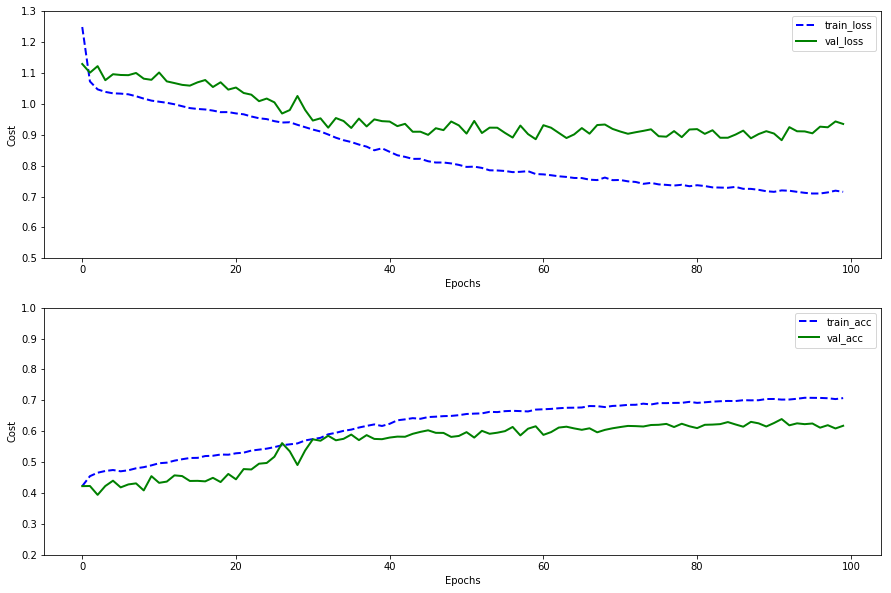

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
plt.ylim([.5,1.3])
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.subplot(2,1,2)
plt.plot(history.history['acc'],'b--',lw=2,label='train_acc')
plt.plot(history.history['val_acc'],'g-',lw=2,label='val_acc')
plt.legend()
plt.ylim([.2,1.])
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [23]:
# predict for each stock
for s in range(5):
    trainx_one,trainoffset_one = select_stocks([s],trainx,trainoffset,len(traindays))
    trainy_one,_=select_stocks([s],trainy,trainoffset,len(traindays))

    valx_one,valoffset_one=select_stocks([s],valx,valoffset,len(valdays))
    valy_one,_=select_stocks([s],valy,valoffset,len(valdays))

    # make our predictions - start from beginning
    # but only predict on ONE Stock
    training_generator=GenerateBatch(trainx_one,trainy_one,trainoffset_one)
    val_generator=GenerateBatch(valx_one,valy_one,valoffset_one)
    train_gen=training_generator.GenerateBatch2(configs['sequence_length'],configs['batch_size'],configs['nflag'])
    val_gen=val_generator.GenerateBatch2(configs['sequence_length'],configs['batch_size'],configs['nflag'])

    # steps per epoch changes for each stock
    steps_per_epoch=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])
    steps_per_epoch_val=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])
    y_train=[]
    yhat_train=[]
    y_val=[]
    yhat_val=[]

    # predict using same sequence lengths and batches as in training - Predict just on one stock
    for i in range(int(steps_per_epoch)):
        dat=next(train_gen)
        y_train.append(dat[1])
        yhat_train.append(m.model.predict(dat[0]))
    for i in range(int(steps_per_epoch_val)):
        dat=next(val_gen)
        y_val.append(dat[1])
        yhat_val.append(m.model.predict(dat[0]))
                                            

    burn_in=0 # drop early predictions 
    y_train=np.concatenate(y_train).reshape(-1,3)[burn_in:]
    yhat_train=np.concatenate(yhat_train).reshape(-1,3)[burn_in:]
    y_val=np.concatenate(y_val).reshape(-1,3)[burn_in:]
    yhat_val=np.concatenate(yhat_val).reshape(-1,3)[burn_in:]


    # How well have we done on training data
    print ("Training for stock %d " % s)
    Y=np.argmax(y_train,axis=1)
    Yhat=np.argmax(yhat_train,axis=1)
    c=confusion_matrix(Y,Yhat)
    c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
    c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
    #print(c)
    print(classification_report(Yhat,Y))
    print("cohen kappa score: %.2f" %cohen_kappa_score(Yhat,Y))
    # How well have we done on test data
    print("Validation for stock %d" % s)
    Y=np.argmax(y_val,axis=1)
    Yhat=np.argmax(yhat_val,axis=1)
    c=confusion_matrix(Y,Yhat)
    c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
    c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
    #print(c)
    print(classification_report(Yhat,Y))
    print("cohen kappa score: %.2f" % cohen_kappa_score(Yhat,Y))

Training for stock 0 
             precision    recall  f1-score   support

          0       0.82      0.55      0.66     13489
          1       0.40      0.70      0.51      1397
          2       0.42      0.68      0.52      5535

avg / total       0.68      0.59      0.61     20421

cohen kappa score: 0.30
Validation for stock 0
             precision    recall  f1-score   support

          0       0.85      0.57      0.68     15361
          1       0.05      0.47      0.10       118
          2       0.33      0.63      0.43      4533

avg / total       0.73      0.58      0.62     20012

cohen kappa score: 0.17
Training for stock 1 
             precision    recall  f1-score   support

          0       0.69      0.83      0.75     14361
          1       0.33      0.56      0.42      2091
          2       0.88      0.70      0.78     21248

avg / total       0.78      0.74      0.75     37700

cohen kappa score: 0.55
Validation for stock 1
             precision    recall  

## 2.  Model Fitting - Second fit on one stock and then predict on that one 



build_model2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 100)               56400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 303       
Total params: 56,703
Trainable params: 56,703
Non-trainable params: 0
_________________________________________________________________
stock 0
trainx_one.shape (20535, 40)
trainy_one.shape (20535, 3)
[Model] Training Started
[Model] 100 epochs, 500 batch size, 44.0 batches per epoch
Epoch 1/100
 - 5s - loss: 1.1714 - acc: 0.4598 - val_loss: 0.9070 - val_acc: 0.4814
Epoch 2/100
 - 2s - loss: 1.0083 - acc: 0.4531 - val_loss: 0.8876 - val_acc: 0.4430
Epoch 3/100
 - 2s - loss: 0.9957 - acc: 0.4719 - val_loss: 0.8907 - val_

Epoch 87/100
 - 2s - loss: 0.8990 - acc: 0.5954 - val_loss: 0.8326 - val_acc: 0.5867
Epoch 88/100
 - 2s - loss: 0.8972 - acc: 0.5968 - val_loss: 0.8351 - val_acc: 0.5819
Epoch 89/100
 - 2s - loss: 0.8984 - acc: 0.5868 - val_loss: 0.8307 - val_acc: 0.5842
Epoch 90/100
 - 2s - loss: 0.8988 - acc: 0.5918 - val_loss: 0.8330 - val_acc: 0.5881
Epoch 91/100
 - 2s - loss: 0.8964 - acc: 0.5920 - val_loss: 0.8248 - val_acc: 0.5976
Epoch 92/100
 - 2s - loss: 0.8965 - acc: 0.5968 - val_loss: 0.8177 - val_acc: 0.6095
Epoch 93/100
 - 2s - loss: 0.8942 - acc: 0.5960 - val_loss: 0.8235 - val_acc: 0.5967
Epoch 94/100
 - 2s - loss: 0.8930 - acc: 0.5954 - val_loss: 0.8262 - val_acc: 0.5949
Epoch 95/100
 - 2s - loss: 0.8909 - acc: 0.5978 - val_loss: 0.8257 - val_acc: 0.5973
Epoch 96/100
 - 2s - loss: 0.8896 - acc: 0.6021 - val_loss: 0.8279 - val_acc: 0.5976
Epoch 97/100
 - 2s - loss: 0.8933 - acc: 0.5954 - val_loss: 0.8360 - val_acc: 0.5825
Epoch 98/100
 - 2s - loss: 0.8960 - acc: 0.5899 - val_loss: 0.838

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 100)               56400     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 303       
Total params: 56,703
Trainable params: 56,703
Non-trainable params: 0
_________________________________________________________________
stock 1
trainx_one.shape (37814, 40)
trainy_one.shape (37814, 3)
[Model] Training Started
[Model] 100 epochs, 500 batch size, 78.0 batches per epoch
Epoch 1/100
 - 7s - loss: 1.1043 - acc: 0.5366 - val_loss: 1.0747 - val_acc: 0.4968
Epoch 2/100
 - 4s - loss: 0.9376 - acc: 0.5567 - val_loss: 1.0703 - val_acc: 0.4984
Epoch 3/100
 - 4s - loss: 0.9158 - acc: 0.5753 - val_loss: 1.0772 - val_acc: 0.5064
E

 - 4s - loss: 0.5156 - acc: 0.8316 - val_loss: 1.1441 - val_acc: 0.5795
Epoch 88/100
 - 4s - loss: 0.5513 - acc: 0.8149 - val_loss: 1.2165 - val_acc: 0.5533
Epoch 89/100
 - 4s - loss: 0.5000 - acc: 0.8362 - val_loss: 1.1738 - val_acc: 0.5822
Epoch 90/100
 - 4s - loss: 0.4880 - acc: 0.8422 - val_loss: 1.1694 - val_acc: 0.5786
Epoch 91/100
 - 4s - loss: 0.4773 - acc: 0.8465 - val_loss: 1.2263 - val_acc: 0.5543
Epoch 92/100
 - 4s - loss: 0.4821 - acc: 0.8472 - val_loss: 1.1878 - val_acc: 0.5847
Epoch 93/100
 - 4s - loss: 0.4842 - acc: 0.8447 - val_loss: 1.2586 - val_acc: 0.5609
Epoch 94/100
 - 4s - loss: 0.4757 - acc: 0.8489 - val_loss: 1.2350 - val_acc: 0.5582
Epoch 95/100
 - 4s - loss: 0.4780 - acc: 0.8482 - val_loss: 1.2052 - val_acc: 0.5843
Epoch 96/100
 - 4s - loss: 0.4769 - acc: 0.8490 - val_loss: 1.2851 - val_acc: 0.5566
Epoch 97/100
 - 4s - loss: 0.4847 - acc: 0.8454 - val_loss: 1.1657 - val_acc: 0.5811
Epoch 98/100
 - 4s - loss: 0.4911 - acc: 0.8428 - val_loss: 1.1652 - val_acc: 

Epoch 65/100
 - 3s - loss: 0.5309 - acc: 0.8220 - val_loss: 1.2060 - val_acc: 0.5564
Epoch 66/100
 - 3s - loss: 0.5150 - acc: 0.8272 - val_loss: 1.2418 - val_acc: 0.5574
Epoch 67/100
 - 3s - loss: 0.5331 - acc: 0.8194 - val_loss: 1.2014 - val_acc: 0.5673
Epoch 68/100
 - 3s - loss: 0.5320 - acc: 0.8189 - val_loss: 1.2051 - val_acc: 0.5542
Epoch 69/100
 - 3s - loss: 0.5477 - acc: 0.8133 - val_loss: 1.2194 - val_acc: 0.5585
Epoch 70/100
 - 3s - loss: 0.5287 - acc: 0.8238 - val_loss: 1.2559 - val_acc: 0.5690
Epoch 71/100
 - 3s - loss: 0.5160 - acc: 0.8296 - val_loss: 1.2923 - val_acc: 0.5605
Epoch 72/100
 - 3s - loss: 0.5156 - acc: 0.8291 - val_loss: 1.3101 - val_acc: 0.5529
Epoch 73/100
 - 3s - loss: 0.5201 - acc: 0.8255 - val_loss: 1.2458 - val_acc: 0.5712
Epoch 74/100
 - 3s - loss: 0.5161 - acc: 0.8275 - val_loss: 1.3160 - val_acc: 0.5523
Epoch 75/100
 - 3s - loss: 0.5078 - acc: 0.8317 - val_loss: 1.2711 - val_acc: 0.5526
Epoch 76/100
 - 3s - loss: 0.5111 - acc: 0.8314 - val_loss: 1.295

Epoch 43/100
 - 5s - loss: 0.8031 - acc: 0.6756 - val_loss: 1.0965 - val_acc: 0.5077
Epoch 44/100
 - 5s - loss: 0.7952 - acc: 0.6802 - val_loss: 1.0656 - val_acc: 0.5252
Epoch 45/100
 - 5s - loss: 0.7850 - acc: 0.6859 - val_loss: 1.0522 - val_acc: 0.5282
Epoch 46/100
 - 5s - loss: 0.7802 - acc: 0.6877 - val_loss: 1.0645 - val_acc: 0.5318
Epoch 47/100
 - 5s - loss: 0.7749 - acc: 0.6923 - val_loss: 1.0887 - val_acc: 0.5161
Epoch 48/100
 - 5s - loss: 0.7678 - acc: 0.6991 - val_loss: 1.0623 - val_acc: 0.5355
Epoch 49/100
 - 5s - loss: 0.7823 - acc: 0.6870 - val_loss: 1.0200 - val_acc: 0.5671
Epoch 50/100
 - 5s - loss: 0.7620 - acc: 0.6998 - val_loss: 1.0622 - val_acc: 0.5348
Epoch 51/100
 - 5s - loss: 0.7478 - acc: 0.7101 - val_loss: 1.0372 - val_acc: 0.5469
Epoch 52/100
 - 5s - loss: 0.7455 - acc: 0.7110 - val_loss: 1.0515 - val_acc: 0.5433
Epoch 53/100
 - 5s - loss: 0.7319 - acc: 0.7178 - val_loss: 1.0167 - val_acc: 0.5734
Epoch 54/100
 - 5s - loss: 0.7388 - acc: 0.7158 - val_loss: 0.994

Epoch 21/100
 - 8s - loss: 1.0876 - acc: 0.3752 - val_loss: 1.1183 - val_acc: 0.3413
Epoch 22/100
 - 8s - loss: 1.0880 - acc: 0.3729 - val_loss: 1.1269 - val_acc: 0.3203
Epoch 23/100
 - 8s - loss: 1.0880 - acc: 0.3745 - val_loss: 1.1238 - val_acc: 0.3269
Epoch 24/100
 - 8s - loss: 1.0878 - acc: 0.3723 - val_loss: 1.1173 - val_acc: 0.3437
Epoch 25/100
 - 8s - loss: 1.0877 - acc: 0.3717 - val_loss: 1.1260 - val_acc: 0.3251
Epoch 26/100
 - 8s - loss: 1.0878 - acc: 0.3707 - val_loss: 1.1274 - val_acc: 0.3217
Epoch 27/100
 - 8s - loss: 1.0879 - acc: 0.3748 - val_loss: 1.1183 - val_acc: 0.3392
Epoch 28/100
 - 8s - loss: 1.0879 - acc: 0.3745 - val_loss: 1.1238 - val_acc: 0.3330
Epoch 29/100
 - 8s - loss: 1.0875 - acc: 0.3735 - val_loss: 1.1304 - val_acc: 0.3205
Epoch 30/100
 - 8s - loss: 1.0876 - acc: 0.3742 - val_loss: 1.1190 - val_acc: 0.3377
Epoch 31/100
 - 8s - loss: 1.0876 - acc: 0.3725 - val_loss: 1.1221 - val_acc: 0.3349
Epoch 32/100
 - 8s - loss: 1.0875 - acc: 0.3707 - val_loss: 1.129

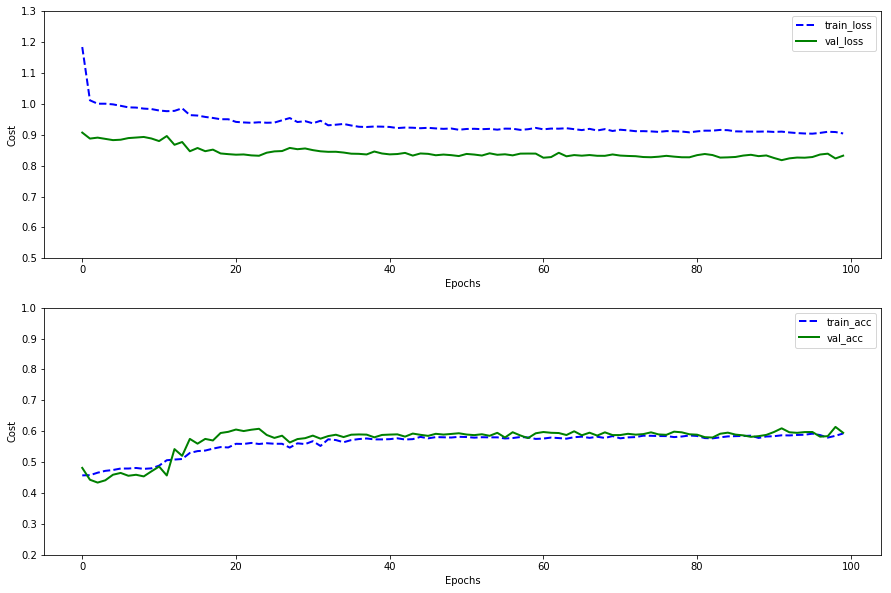

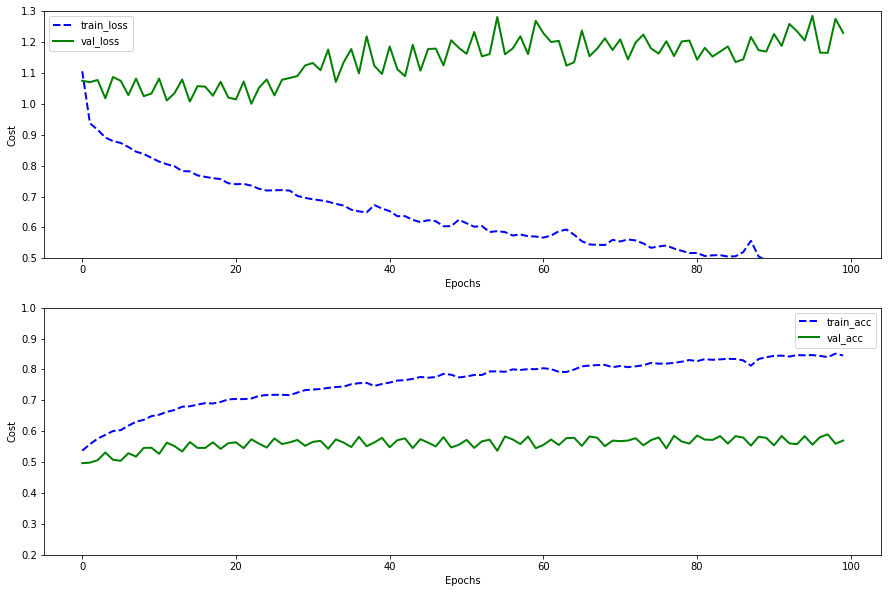

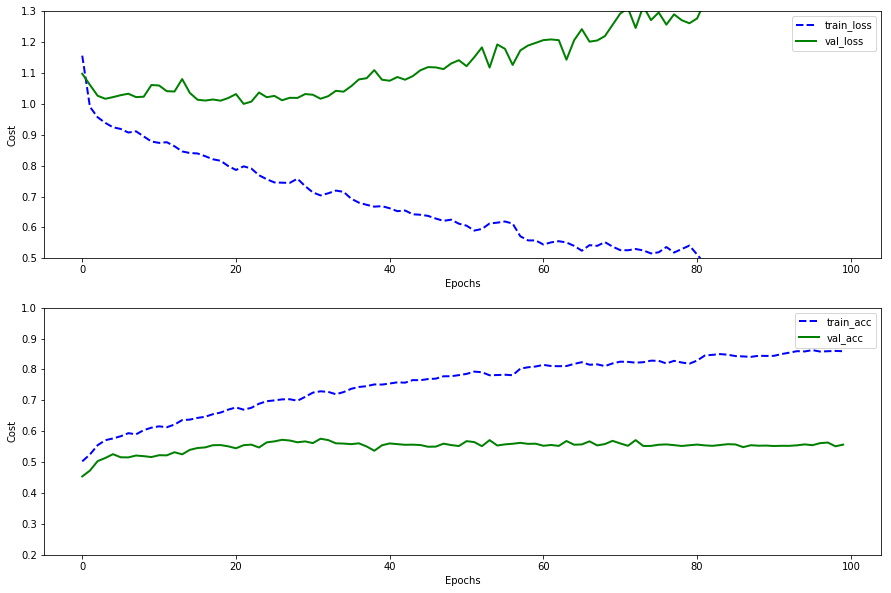

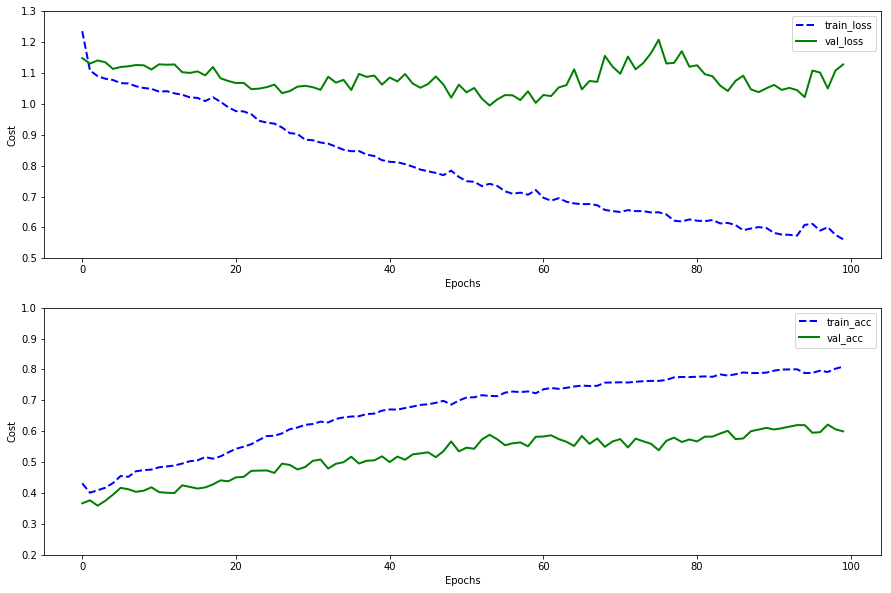

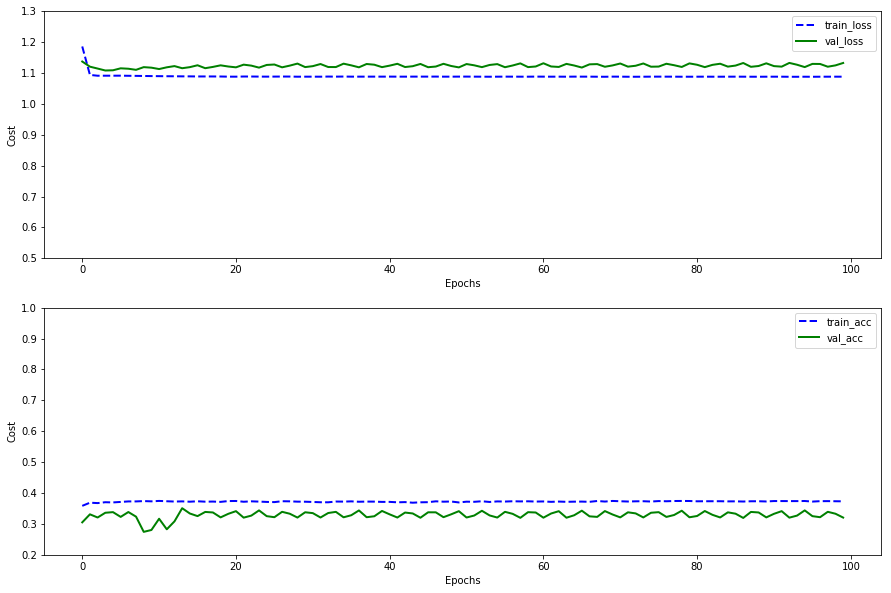

In [31]:
# Do the whole thing for each stock -- later should break this up into separate functions
# rather than repeating from above
dat_train=[] # save data for each stock for later display
dat_val=[]
kappa_train=[]
kappa_val=[]

for s in range(5):
    #build a new model for each stock s
    m_one=Model()
    m_one.build_model(configs['sequence_length'],len(colx))
    #select data for stock s
    trainx_one,trainoffset_one = select_stocks([s],trainx,trainoffset,len(traindays))
    trainy_one,_=select_stocks([s],trainy,trainoffset,len(traindays))
    print("stock %d" % s)
    print("trainx_one.shape",trainx_one.shape)
    print("trainy_one.shape",trainy_one.shape)

    valx_one,valoffset_one=select_stocks([s],valx,valoffset,len(valdays))
    valy_one,_=select_stocks([s],valy,valoffset,len(valdays))
    
    # create generator for stock s
    training_generator=GenerateBatch(trainx_one,trainy_one,trainoffset_one)
    val_generator=GenerateBatch(valx_one,valy_one,valoffset_one)

    # steps per epoch
    steps_per_epoch=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])
    steps_per_epoch_val=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])

    # GenerateBatch2 contains logic to avoid running over stock/day divides
    history=train_generator(
        model=m_one.model,
        train_gen=training_generator.GenerateBatch2(configs['sequence_length'],
                                               configs['batch_size'],
                                               configs['nflag']),
        val_gen=val_generator.GenerateBatch2(configs['sequence_length'],
                                        configs['batch_size'],
                                        configs['nflag']),
        epochs=configs['epochs'],
        batch_size=configs['batch_size'],
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch_val,
        save_dir=configs['save_dir']
        )

    

    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
    plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
    plt.legend()
    plt.ylim([.5,1.3])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.subplot(2,1,2)
    plt.plot(history.history['acc'],'b--',lw=2,label='train_acc')
    plt.plot(history.history['val_acc'],'g-',lw=2,label='val_acc')
    plt.legend()
    plt.ylim([.2,1.])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.savefig('loss_one %d' % s)
    
    

    # make our predictions - start from beginning
    # but only predict on ONE Stock
    train_gen=training_generator.GenerateBatch2(configs['sequence_length'],configs['batch_size'],configs['nflag'])
    val_gen=val_generator.GenerateBatch2(configs['sequence_length'],configs['batch_size'],configs['nflag'])

    y_train=[]
    yhat_train=[]
    y_val=[]
    yhat_val=[]

    # predict using same sequence lengths and batches as training -- Predict just on one stock
    for i in range(int(steps_per_epoch)):
        dat=next(train_gen)
        y_train.append(dat[1])
        yhat_train.append(m_one.model.predict(dat[0]))
    for i in range(int(steps_per_epoch_val)):
        dat=next(val_gen)
        y_val.append(dat[1])
        yhat_val.append(m_one.model.predict(dat[0]))
                                            

    burn_in=0 # drop early predictions 
    y_train=np.concatenate(y_train).reshape(-1,3)[burn_in:]
    yhat_train=np.concatenate(yhat_train).reshape(-1,3)[burn_in:]
    y_val=np.concatenate(y_val).reshape(-1,3)[burn_in:]
    yhat_val=np.concatenate(yhat_val).reshape(-1,3)[burn_in:]


    # How well have we done on training data
    print ("Training %d " %s)
    Y=np.argmax(y_train,axis=1)
    Yhat=np.argmax(yhat_train,axis=1)
    c=confusion_matrix(Y,Yhat)
    c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
    c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
    #print(c)
    cr=classification_report(Yhat,Y)
    print(cr)
    dat_train.append(cr)
    ck=cohen_kappa_score(Yhat,Y)
    print("cohen kappa score: %.2f" % ck)
    kappa_train.append(ck)
    # How well have we done on test data
    print("Validation %d " %s)
    Y=np.argmax(y_val,axis=1)
    Yhat=np.argmax(yhat_val,axis=1)
    c=confusion_matrix(Y,Yhat)
    c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
    c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
    #print(c)
    cr=classification_report(Yhat,Y)
    print(cr)
    dat_val.append(cr)
    ck=cohen_kappa_score(Yhat,Y)
    print("cohen kappa score: %.2f" % ck)
    kappa_val.append(ck)

In [36]:
#classification reports for training data (one stock case)
for i,j in enumerate(dat_train):
    print(i)
    print(j)

0
             precision    recall  f1-score   support

          0       0.60      0.63      0.61      8560
          1       0.00      0.00      0.00         5
          2       0.76      0.58      0.66     11856

avg / total       0.69      0.60      0.64     20421

1
             precision    recall  f1-score   support

          0       0.77      0.83      0.80     16099
          1       0.30      0.69      0.42      1531
          2       0.89      0.75      0.81     20070

avg / total       0.82      0.78      0.79     37700

2
             precision    recall  f1-score   support

          0       0.87      0.84      0.86     14168
          1       0.56      0.86      0.68      2791
          2       0.89      0.82      0.85     14736

avg / total       0.85      0.83      0.84     31695

3
             precision    recall  f1-score   support

          0       0.82      0.75      0.78     19301
          1       0.68      0.83      0.75      9272
          2       0.79      

In [37]:
#classification reports for validation data
for i,j in enumerate(dat_val):
    print(i)
    print(j)

0
             precision    recall  f1-score   support

          0       0.58      0.65      0.61      9095
          1       0.00      0.00      0.00         0
          2       0.69      0.55      0.61     10917

avg / total       0.64      0.59      0.61     20012

1
             precision    recall  f1-score   support

          0       0.58      0.62      0.60     14883
          1       0.04      0.32      0.08       847
          2       0.77      0.55      0.64     21638

avg / total       0.68      0.57      0.61     37368

2
             precision    recall  f1-score   support

          0       0.64      0.59      0.61     13800
          1       0.18      0.49      0.26      2484
          2       0.68      0.54      0.60     15302

avg / total       0.62      0.56      0.58     31586

3
             precision    recall  f1-score   support

          0       0.64      0.57      0.61     17458
          1       0.51      0.70      0.59     11846
          2       0.66      

In [38]:
print(kappa_train)

[0.28100109134848394, 0.6112757562551434, 0.7204965931348986, 0.6504642575355988, 0.0]


In [39]:
print(kappa_val)

[0.23526685952820492, 0.2698177675146358, 0.28616284928723557, 0.3998143826728917, 0.0]
